### Plot station timeseries

#### TLDR in train:

- Changed color of timeseries
- Calculated SIE for each month
- Calculated various correlations with SIE:
1) For each station and each month
2) For each cluster and each month
3) For each cluster using the entire timeseries
4) For both clusters using the entire timeseries

##### Results of this:

1) In August: 0.37/0.14 with pval <=0.02 for EG-IV, in October: 0.32-0.34/0.10 with pval <=0.05
2) No significant correlation for either cluster in any month
3) EG cluster: 0.65/0.42, N cluster: 0.16/0.03, both with pval 0.0
4) 0.54/0.29, pval 0.0

#### Purpose: Plot timeseries of SIC variability at Hausgarten stations

#### Modules and functions

In [ ]:
import numpy as np
import pylab as plt
import xarray as xr
import os,sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import calendar
from scipy.stats import linregress,pearsonr
import pymannkendall as mk
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [4]:
def makenice(ax,fontsize_title = 20, fontsize_labels = 16):
    # ax.set_xlabel('Date', fontsize=fontsize_labels)
    ax.set_ylabel('SIC [%]', fontsize=fontsize_title)
    #ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    ax.tick_params(labelsize = fontsize_labels)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())

In [5]:
def convert_to_decimal_degrees(coord_str):
    # Remove the degree symbol and split the string
    degree_str, minute_str_with_direction = coord_str.split('°')
    minute_str, direction = minute_str_with_direction.split("'")

    # Remove any commas from the minute string and convert to float
    minutes = float(minute_str.replace(',', '.'))

    # Convert degree string to float
    degrees = float(degree_str)

    # Calculate decimal degrees
    decimal_degrees = degrees + minutes / 60

    # If the direction is 'S' or 'W', make the decimal degrees negative
    if direction.strip() in ['S', 'W']:
        decimal_degrees = -decimal_degrees

    return decimal_degrees

In [6]:
def get_coorddicts(df):
    londict = {stationname:np.round(lon,3) for stationname,lon in zip(df["Station ID"],df["lon_decimal"])}
    latdict = {stationname:np.round(lat,3) for stationname,lat in zip(df["Station ID"],df["lat_decimal"])}
    return londict,latdict

In [7]:
date_range = pd.date_range(start='1987-01', end='2024-12', freq='MS')

In [8]:
def makeplot(ax,df_station,posdict,col,fontsize_legend = 16,fontsize_title = 20,fontsize_labels = 16,elinewidth = .5,ecolor = "lightgrey",zorder_line = 3, zorder_errorbar = 2,xtickrot = 0):
    date_range = pd.date_range(start='1987-01', end='2024-12', freq='MS')
    mean_line, = ax.plot(date_range, df_station["sic_mean"].values, 
                          label='SIC monthly mean', color=col, linestyle='-', 
                          marker='o', markersize=6, linewidth=2, alpha=0.8,zorder = zorder_line)
    
    # Plot the error bars separately
    errorbars = ax.errorbar(date_range, df_station["sic_mean"].values, 
                             yerr=df_station["sic_std"].values, 
                             fmt='none',  # No markers, only error bars
                             ecolor=ecolor,  # Color of error bars
                             capsize=5,  # Size of error bar caps
                             elinewidth=elinewidth,  # Width of error lines
                             label='SIC monthly standard deviation',zorder = zorder_errorbar)  # Error bars label
    
    # Customize the plot
    ax.set_title(f'{posdict[df_station["station_id"][0]]}{df_station["station_id"][0]}', fontsize=fontsize_title, fontweight='bold')
    #ax.set_xlabel('Date', fontsize=fontsize_labels)
    ax.set_ylabel('SIC [%]', fontsize=fontsize_title)
    ax.tick_params(labelsize = fontsize_labels)
    if df_station["station_id"][0] == "N3":
        ax.legend(fontsize=fontsize_labels, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    # Improve x-axis formatting
    ax.tick_params(axis='x', labelrotation=xtickrot)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    if df_station["station_id"][0].startswith("EG"):
        xpos = 0.05
        ypos = .1
    elif df_station["station_id"][0].startswith("N"):
        xpos = .8
        ypos = .75
    ax.text(xpos,ypos,r"$\mu$" + f": {np.nanmean(df_station["sic_mean"].values):.01f} \n" + r"$\sigma$" + f": {np.nanstd(df_station["sic_mean"].values):.01f}",transform=ax.transAxes,fontsize = fontsize_labels, bbox=dict(
        boxstyle="round,pad=0.3",  # Rounded box with padding
        edgecolor='black',  # No border color
        facecolor='lightgrey',  # Light yellow background
        alpha=0.7  # Semi-transparent background
    ))
    #ax.text(xpos,ypos-.1,r"$\sigma$" + f": {np.nanstd(df_station["sic_mean"].values):.01f}",transform=ax.transAxes,fontsize = fontsize_labels, bbox=dict(
    #    boxstyle="round,pad=0.3",  # Rounded box with padding
    #    edgecolor='black',  # No border color
    #    facecolor='lightblue',  # Light yellow background
    #    alpha=0.7  # Semi-transparent background
    #))
    ax.set_ylim(0, 110)

In [9]:
def design_map(ax,title,hemisphere,fontsize_title = 20):
    if hemisphere == "nh":
        ax.set_extent([-30, 30, 58,85], ccrs.PlateCarree())
    elif hemisphere == "sh":
        ax.set_extent([-180, 180, -60,-90], ccrs.PlateCarree())
    else:
        sys.exit("Hemisphere needs to be either 'nh' or 'sh'!")
    ax.set_title(title,fontsize = fontsize_title) # set title
    ax.coastlines()
    ax.gridlines()
    #ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5E5A0')  # Adjust facecolor as needed
    ax.add_feature(cfeature.LAND, facecolor='#f5e5a0')  # Light brown for land
    ax.add_feature(cfeature.OCEAN, facecolor='#a0c9f5')  # Light blue for ocean
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)  # Black coastline outline
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5E5A0')  # Light tan for land areas
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')  # Lakes in light blue
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')  # Political boundaries (optional)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)  # Rivers in blue

    #ax.set_facecolor('#F5F5F5')
    #ax.gridlines().label_style = {'fontsize': 14}
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, alpha=0.5, linestyle='--', draw_labels=True)
    #gl.xlabel_style = {'size': 14, 'color': 'black'}
    #gl.ylabel_style = {'size': 14, 'color': 'black'}

In [10]:
def get_dfdict(datadir,station_ids,firstyear,lastyear):
    dfdict = {}
    for station_id in station_ids:
        if os.path.exists(os.path.join(datadir,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
            df_station = pd.read_csv(os.path.join(datadir,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
        dfdict[station_id] = df_station
    return dfdict

In [11]:
def get_dirs(date):
    if os.path.exists("/Users/vludwig/"):
        basedir = "/Users/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/Users/vludwig/06_HAUSGARTEN/03_PLOTS/"
        # plotdir_paper = "/Users/vludwig/02_LITERATURE/01_PAPERS/04_OWN/04_HAUSGARTEN/02_TEX/01_V1/01_INPUT/01_FIGURES/"
        plotdir_paper = f"/Users/vludwig/02_LITERATURE/01_PAPERS/04_OWN/04_HAUSGARTEN/02_TEX/02_COLLABTEX/01_VERSIONS/{date}/02_FIGURES"
        datadir_csv = os.path.join(basedir,"01_CSV")
        #datadir_nc = os.path.join(basedir,"02_NETCDF/01_MONTHLY")
        datadir_nc = os.path.join(basedir,"02_NETCDF/02_MONTHLY_OWN")
    else:
        basedir = "/albedo/work/user/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/albedo/home/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        datadir_nc = "/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/"
    return basedir,plotdir,plotdir_paper,datadir_csv,datadir_nc

In [107]:
def make_boxplot(arr,ax,col,title = "Boxplot",position = 1):
    bp = ax.boxplot(
    arr[~np.isnan(arr)],  # Removing NaN values
    vert=True,  # Horizontal boxplot
    patch_artist=True,  # Fill the boxes with color
    #notch=True,  # Notch for median line
    widths=0.2,  # Box width
    boxprops=dict(facecolor=col, color='black',alpha = .8),  # Box color
    whiskerprops=dict(color='black', linewidth=1.5,alpha = .8),  # Whisker color and thickness
    capprops=dict(color='black', linewidth=1.5),  # Cap color and thickness
    flierprops=dict(marker='o', markerfacecolor=col, markersize=8, linestyle='none', alpha=0.8),  # Outliers
    medianprops=dict(color='black', linewidth=2),  # Median line color
    meanprops=dict(marker='*', markerfacecolor='black',markeredgecolor='black', markersize=12),  # Mean marker
    showmeans = True,
        positions = [position]
)
    ax.set_title(title, fontsize=fontsize_title,fontweight = "bold")
    ax.set_xlabel('SIC Difference',fontsize = fontsize_labels)
    ax.tick_params(axis='y', labelsize=fontsize_labels)  # Adjust label size
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_xticks([])
    return bp

In [103]:
def make_boxplot2(arr1,arr2,ax,col,title = "Boxplot"):
    bp = ax.boxplot(
    [arr1[~np.isnan(arr1)],arr2[~np.isnan(arr2)]],  # Removing NaN values
    vert=True,  # Horizontal boxplot
    patch_artist=True,  # Fill the boxes with color
    #notch=True,  # Notch for median line
    widths=0.2,  # Box width
    boxprops=[
        dict(facecolor=col[0], color='black', alpha=0.8),  # Box color for first box
        dict(facecolor=col[1], color='black', alpha=0.8)   # Box color for second box
    ],
    whiskerprops=dict(color='black', linewidth=1.5,alpha = .8),  # Whisker color and thickness
    capprops=dict(color='black', linewidth=1.5),  # Cap color and thickness
    flierprops=dict(marker='o', markerfacecolor=col[0], markersize=8, linestyle='none', alpha=0.8),  # Outliers
    medianprops=dict(color='black', linewidth=2),  # Median line color
    meanprops=dict(marker='*', markerfacecolor='black',markeredgecolor='black', markersize=12),  # Mean marker
    showmeans = True
)
    ax.set_title(title, fontsize=fontsize_title,fontweight = "bold")
    ax.set_xlabel('SIC Difference',fontsize = fontsize_labels)
    ax.tick_params(axis='y', labelsize=fontsize_labels)  # Adjust label size
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_xticks([])
    return bp

In [13]:
def col2cluster(cluster):
    if cluster=="EG":
        col = "salmon"
    elif cluster=="N":
        col = "royalblue"
    else:
        print(f"Cluster {cluster} unknown")
    return col

#### Load data

In [14]:
firstyear = 1987
lastyear = 2024
month = 7

In [15]:
today = datetime.datetime.strftime(datetime.datetime.now(),"%Y%m%d")
day_of_processing = "20241112"

In [16]:
basedir,plotdir_tmp,plotdir_paper,datadir_csv,datadir_nc = get_dirs(today)
plotdir = os.path.join(plotdir_tmp,"01_TIMESERIES")


In [17]:
#if False:
#    fns_1999 = [fn for fn in glob.glob(os.path.join(datadir_nc,f"ice_conc_nh_ease2-250_cdr-v3p0_1999*{month:02}.nc"))]
#    fns_2000_2024 = [fn for fn in glob.glob(os.path.join(datadir_nc,f"ice_conc_nh_ease2-250_*-v3p0_20*{month:02}.nc"))]
#    fns = list(np.sort(fns_1999+fns_2000_2024))

In [18]:
#ds = xr.open_mfdataset(fns)

#### Plot timeseries

In [19]:
# Define the list of Station IDs you want to filter by
station_ids = ['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']

In [20]:

df_hausgarten = pd.read_excel(os.path.join(datadir_csv,"average HG-Stations.xlsx"))
# Select rows where "Station ID" is in the specified list
hausgarten_ice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids)]
hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
londict,latdict = get_coorddicts(hausgarten_ice)

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2025660164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2025660164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]


In [21]:
station_ids_by_lon = sorted(londict, key=lambda k: londict[k])

##### One plot per station

In [22]:
## Fontsizes
fontsize_labels = 16
fontsize_title = 20
fontsize_suptitle = 24

Station EG-I


TypeError: makeplot() missing 2 required positional arguments: 'posdict' and 'col'

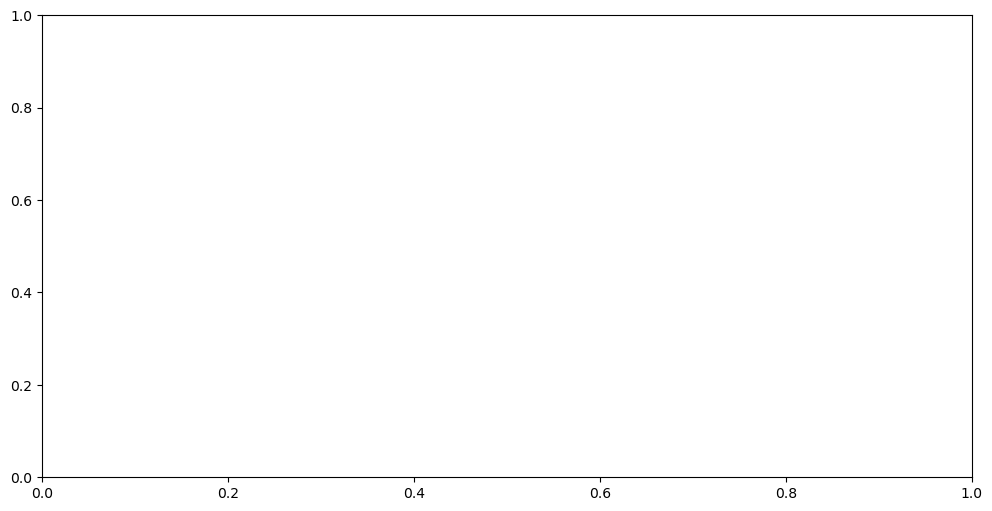

In [23]:
## Stations separately
for station_id in station_ids:
    fig, ax = plt.subplots(figsize=(12, 6))
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
        print(f"Station {station_id}")
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
        makeplot(ax,df_station)
        plt.tight_layout()
        fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.pdf"),dpi = 150,bbox_inches = "tight")
# Plot the mean values with error bars
        #plt.close(fig)
        fig.show()

In [24]:
viridis_colors_tmp = plt.cm.viridis(np.linspace(0,1,len(station_ids)))
viridis_colors = np.zeros_like(viridis_colors_tmp)
viridis_colors[0:4,:] = viridis_colors_tmp[0:4,:].copy()
viridis_colors[4:,:] = viridis_colors_tmp[4:,:][::-1].copy()

In [25]:
axpos = [7,5,3,1,6,4,2]

In [26]:
years = list(range(firstyear, lastyear+1))
months = [f"{d:02d}" for d in range(1,13)]

In [27]:
len(years)*12

456

In [28]:
data_station = {}
for station_id in station_ids_by_lon:
    data_station[station_id] = np.repeat(np.nan,len(years)*12)
data_station_dates = data_station.copy()
data_station_dates["year"] = np.repeat(years,len(months))
data_station_dates["month"] = months*len(years)
# Create the DataFrame
df_station_all = pd.DataFrame(data_station)
df_station_all_dates = pd.DataFrame(data_station_dates)

In [29]:
for i,station_id in enumerate(station_ids_by_lon):
    
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
        df_station_all[station_id] = df_station["sic_mean"]
        df_station_all_dates[station_id] = df_station["sic_mean"]
        

In [30]:
inflate_factor_stations = 30
inflate_factor_years = 3

repeated_dfs = [df_station_all.add_suffix(f"_{i+1}") for i in range(inflate_factor_stations)]

# Concatenate the repeated DataFrames column-wise in an interleaved order
inflated_df_stations = pd.concat(repeated_dfs, axis=1)

# Rearrange the columns so each original column's repeats are next to each other
column_order = [f"{col}_{i+1}" for col in df_station_all.columns for i in range(inflate_factor_stations)]
inflated_df_stations = inflated_df_stations[column_order]
inflated_df_years = inflated_df_stations.loc[inflated_df_stations.index.repeat(inflate_factor_years)].reset_index(drop=True)


In [31]:
years_inflated = np.zeros(inflated_df_years.shape[0])
#sic_stations_inflated = np.zeros((inflated_df_years.shape[0],)

In [32]:
years = np.arange(1987,2025)

In [33]:
counter = 0
for year in years:
    print(counter,counter+12*inflate_factor_years,year)
    
    years_inflated[(counter):(counter+12*inflate_factor_years)] = year
    counter+=36

0 36 1987
36 72 1988
72 108 1989
108 144 1990
144 180 1991
180 216 1992
216 252 1993
252 288 1994
288 324 1995
324 360 1996
360 396 1997
396 432 1998
432 468 1999
468 504 2000
504 540 2001
540 576 2002
576 612 2003
612 648 2004
648 684 2005
684 720 2006
720 756 2007
756 792 2008
792 828 2009
828 864 2010
864 900 2011
900 936 2012
936 972 2013
972 1008 2014
1008 1044 2015
1044 1080 2016
1080 1116 2017
1116 1152 2018
1152 1188 2019
1188 1224 2020
1224 1260 2021
1260 1296 2022
1296 1332 2023
1332 1368 2024


#### Below: Map, stations and heatmap

In [34]:
inds_heatmap = np.arange(0,inflated_df_years.shape[0],12*inflate_factor_years)[::1]
inds_heatmap_minor = np.arange(0,inflated_df_years.shape[0],12*inflate_factor_years)
labels_heatmap = [f"{y:0.0f}" for y in years_inflated[inds_heatmap]]

In [35]:
## Fontsizes
fontsize_labels = 16
fontsize_title = 20
fontsize_suptitle = 24

#### MAKING PLOTS STARTS HERE 

EG-I: 5.05/6.65 (median/mean)
EG-II: 7.09/8.58 (median/mean)
EG-III: 7.09/8.58 (median/mean)
EG-IV: 10.8/11.5 (median/mean)
N5: 10.8/11.2 (median/mean)
N4: 8.89/9.0 (median/mean)
N3: 3.76/5.16 (median/mean)


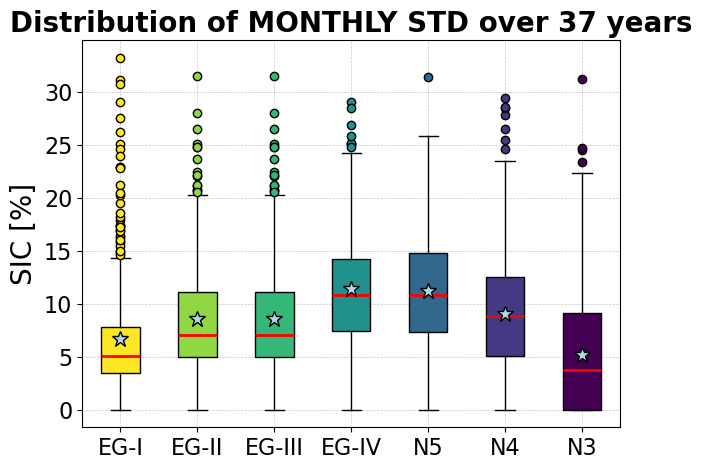

In [36]:
### THIS CELL PLOTS BOXPLOT WITH STD DEVS. NOT SAVED FOR PAPER. ###

## PREPARATIONS
fig = plt.figure()
#fig.suptitle("Monthly averaged OSI SAF SIC at selected Hausgarten stations",fontweight = "bold",fontsize = fontsize_suptitle,y = .99)
# Define the GridSpec layout
ax = fig.add_subplot(111)

## PLOT MAP
boxplot_data = []
for station_id in station_ids_by_lon:
    #print(station_id)
    filepath = os.path.join(datadir_csv, f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")
    if os.path.exists(filepath):
        df_station = pd.read_csv(filepath)
        boxplot_data.append(df_station["sic_std"].values[~np.isnan(df_station["sic_std"].values)])
        print(f"{station_id}: {np.nanmedian(df_station["sic_std"]):.3}/{np.nanmean(df_station["sic_std"]):.3} (median/mean)")

# Plot boxplots
colors = [viridis_colors[i] for i in range(len(boxplot_data))][::-1]  # Use the same colors as for the time series
colors_manip = colors[:3][::-1]+colors[3:] # make sure that colors show pu in the right order in boxplot
bp = ax.boxplot(boxplot_data, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(markerfacecolor="blue", marker="o", alpha=1),
            meanprops=dict(marker='*', markerfacecolor='lightblue',markeredgecolor='black', markersize=12),
            showmeans = True)
for patch, color in zip(bp['boxes'], colors_manip):  # Assign colors to each box
    patch.set_facecolor(color)
for flier, color in zip(bp['fliers'], colors_manip):
    flier.set_markerfacecolor(color)
    #flier.set_markeredgecolor(color)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
#fig.show()
#sys.exit()
# Customize boxplot axes
ax.set_title("Distribution of MONTHLY STD over 37 years", fontsize=fontsize_title, fontweight="bold")
ax.set_xticks(range(1, len(boxplot_data) + 1))
ax.set_xticklabels(station_ids_by_lon, fontsize=fontsize_labels)
ax.set_ylabel("SIC [%]", fontsize=fontsize_title)
ax.tick_params(labelsize=fontsize_labels)


plt.tight_layout()
#fig.savefig(os.path.join(plotdir,f"hausgarten_std_boxplots_{firstyear}-{lastyear}_{today}.pdf"),bbox_inches = "tight")
#fig.savefig(os.path.join(plotdir_paper,f"hausgarten_sic_timeseries_boxplots_heatmap_{firstyear}-{lastyear}.pdf"),bbox_inches = "tight")
plt.show()




MK Test yielded no trend for station EG-IV, with a pvalue of 0.122 and a slope of -0.0117
MK Test yielded no trend for station N3, with a pvalue of 0.201 and a slope of 0.0
MK Test yielded no trend for station N4, with a pvalue of 0.389 and a slope of -0.000855
MK Test yielded no trend for station N5, with a pvalue of 0.387 and a slope of -0.00792
MK Test yielded decreasing for station EG-III, with a pvalue of 0.049 and a slope of -0.0106
MK Test yielded decreasing for station EG-II, with a pvalue of 0.049 and a slope of -0.0106
MK Test yielded decreasing for station EG-I, with a pvalue of 0.045 and a slope of -0.00727


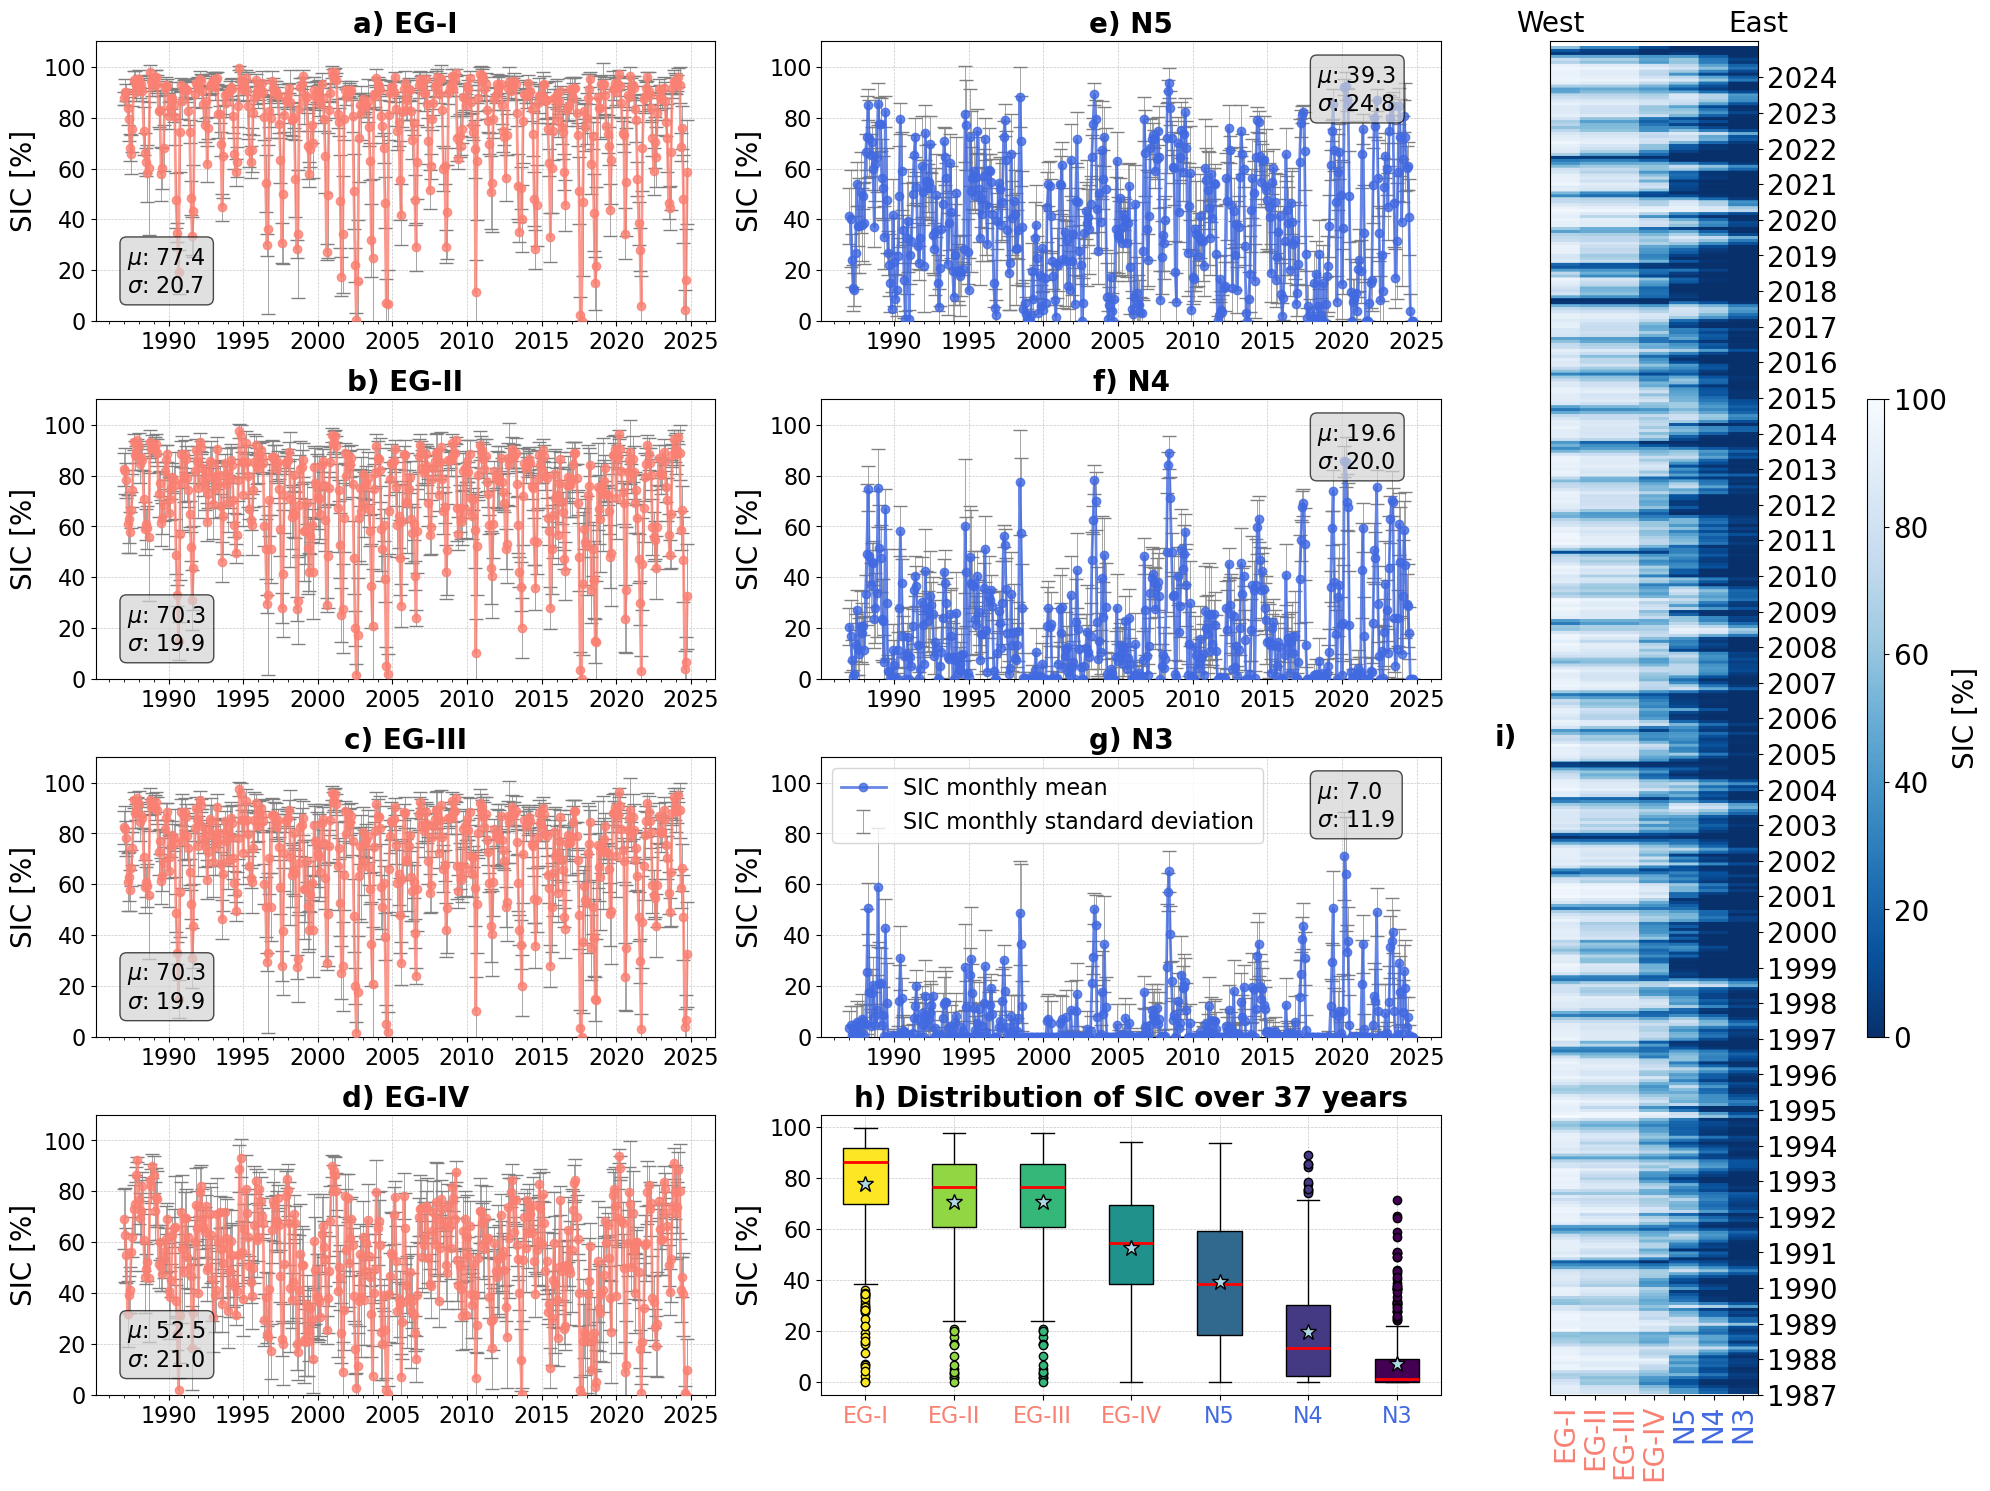

In [113]:
### THIS CELL PLOTS THE SUBPLOT WITH A BOXPLOT OF THE STATIONS ###

## PREPARATIONS
fig = plt.figure(figsize = (20,15))
#fig.suptitle("Monthly averaged OSI SAF SIC at selected Hausgarten stations",fontweight = "bold",fontsize = fontsize_suptitle,y = .99)
# Define the GridSpec layout
gs = gridspec.GridSpec(4,6, width_ratios=[3,3,3,3, 2.5,.2])  # Left three columns are wider

## CREATE SUBPLOTS
# Create the Cartopy map in the top-left position, spanning the first two columns
ax1 = fig.add_subplot(gs[3, 2:4]) # boxplots
# First index: row, second index: column(s) 
ax2 = fig.add_subplot(gs[3, :2])  # EG-IV
ax3 = fig.add_subplot(gs[2, 2:4])  # N3
ax4 = fig.add_subplot(gs[1, 2:4])  # N4
ax5 = fig.add_subplot(gs[0, 2:4])  # N5
#ax6 = fig.add_subplot(gs[4, :2])  
ax6 = fig.add_subplot(gs[2, :2]) # EG-III
ax7 = fig.add_subplot(gs[1, :2])  # EG-II
ax8 = fig.add_subplot(gs[0, :2]) # EG-I
ax9 = fig.add_subplot(gs[:, 4])  # Entire right column

## PLOT MAP
boxplot_data = []
for station_id in station_ids_by_lon:
    #print(station_id)
    filepath = os.path.join(datadir_csv, f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")
    if os.path.exists(filepath):
        df_station = pd.read_csv(filepath)
        boxplot_data.append(df_station["sic_mean"].values[~np.isnan(df_station["sic_mean"].values)])

# Plot boxplots
colors = [viridis_colors[i] for i in range(len(boxplot_data))][::-1]  # Use the same colors as for the time series
colors_manip = colors[:3][::-1]+colors[3:] # make sure that colors show up in the right order in boxplot
bp = ax1.boxplot(boxplot_data, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(markerfacecolor="blue", marker="o", alpha=1),
            meanprops=dict(marker='*', markerfacecolor='lightblue',markeredgecolor='black', markersize=12),
            showmeans = True)
for patch, color in zip(bp['boxes'], colors_manip):  # Assign colors to each box
    patch.set_facecolor(color)
for flier, color in zip(bp['fliers'], colors_manip):
    flier.set_markerfacecolor(color)
    #flier.set_markeredgecolor(color)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
#fig.show()
#sys.exit()
# Customize boxplot axes
ax1.set_title("h) Distribution of SIC over 37 years", fontsize=fontsize_title, fontweight="bold")
ax1.set_xticks(range(1, len(boxplot_data) + 1))
ax1.set_xticklabels(station_ids_by_lon, fontsize=fontsize_labels)
for xtick, color in zip(ax1.get_xticklabels(), [col2cluster("EG")]*4 + [col2cluster("N")]*3):
    xtick.set_color(color)
ax1.set_ylabel("SIC [%]", fontsize=fontsize_title)
ax1.tick_params(labelsize=fontsize_labels)

## PLOT TIMESERIES
posdict = {"EG-IV":"d) ","N3":"g) ","N4":"f) ","N5":"e) ","EG-III":"c) ","EG-II":"b) ","EG-I":"a) "}
for i,station_id,ax in zip(range(0,7),["EG-IV","N3","N4","N5","EG-III","EG-II","EG-I"],[ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    if station_id.startswith("EG"):
        col = col2cluster("EG")
    else:
        col = col2cluster("N")
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
        ax.set_title(station_id)
        makeplot(ax,df_station,posdict,col = col, fontsize_legend = fontsize_labels,fontsize_labels=fontsize_labels,fontsize_title = fontsize_title,elinewidth = .5,ecolor = "grey",xtickrot = 0)
        mktest =  mk.original_test(df_station["sic_mean"].values)
        print(f"MK Test yielded {mktest[0]} for station {station_id}, with a pvalue of {mktest[2]:.03f} and a slope of {mktest[-2]:0.003}")

        #fig.show()
        #sys.exit()
        
## HEATMAP
fig.text(.75,.5,"i)", fontweight = "bold", fontsize = fontsize_title)
ax9.yaxis.tick_right() # move yticks to right side
im = ax9.imshow(np.flipud(inflated_df_years),cmap = plt.cm.Blues_r,vmin = 0, vmax = 100) # show image
# YTICKS
ax9.set_yticks(inflated_df_years.shape[0]-inds_heatmap)
ax9.set_yticklabels(labels_heatmap,fontsize = fontsize_title)
#ax9.yaxis.set_minor_locator(MultipleLocator(inflate_factor_years))
# XTICKS
ax9.set_xticks(np.arange(0,inflated_df_years.shape[1],inflate_factor_stations) + inflate_factor_stations/2)
ax9.set_xticklabels(station_ids_by_lon,rotation = 90,fontsize = fontsize_title)
for xtick, color in zip(ax9.get_xticklabels(), [col2cluster("EG")]*4 + [col2cluster("N")]*3):
    xtick.set_color(color)

# TEXT
ypos = -10
ax9.text(0,ypos,"West",fontsize = fontsize_title,ha = "center")
ax9.text(inflated_df_years.shape[-1],ypos,"East",fontsize = fontsize_title,ha = "center")
# COLORBAR
cbar_ax = fig.add_subplot(gs[1:3, 5])
cb = fig.colorbar(im, cax=cbar_ax,orientation = "vertical")
cb.ax.tick_params(labelsize = fontsize_title)
cb.set_label("SIC [%]",fontsize = fontsize_title)
# FINISH AND SAVE
# Show the plot
plt.tight_layout()
fig.savefig(os.path.join(plotdir,f"hausgarten_sic_timeseries_boxplots_heatmap_{firstyear}-{lastyear}_{today}.pdf"),bbox_inches = "tight")
for ending in [".png",".pdf"]:
    fig.savefig(os.path.join(plotdir_paper,f"hausgarten_sic_timeseries_boxplots_heatmap_{firstyear}-{lastyear}{ending}"),bbox_inches = "tight")
plt.show()




In [38]:
### THIS CELL PLOTS THE SUBPLOT WITH A MAP OF THE STATIONS ###

## PREPARATIONS
if False:
    fig = plt.figure(figsize = (20,15))
    fig.suptitle("Monthly averaged OSI SAF SIC at selected Hausgarten stations",fontweight = "bold",fontsize = fontsize_suptitle,y = .99)
    # Define the GridSpec layout
    gs = gridspec.GridSpec(4,6, width_ratios=[3,3,3,3, 2.5,.2])  # Left three columns are wider
    
    ## CREATE SUBPLOTS
    # Create the Cartopy map in the top-left position, spanning the first two columns
    ax1 = fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree()) # upper left
    # First index: row, second index: column(s)
    ax2 = fig.add_subplot(gs[0, 2:4])  
    ax3 = fig.add_subplot(gs[1, :2])  
    ax4 = fig.add_subplot(gs[2, :2])  
    ax5 = fig.add_subplot(gs[3, :2])  
    #ax6 = fig.add_subplot(gs[4, :2])  
    ax6 = fig.add_subplot(gs[1, 2:4]) 
    ax7 = fig.add_subplot(gs[2, 2:4])  
    ax8 = fig.add_subplot(gs[3, 2:4]) 
    ax9 = fig.add_subplot(gs[:, 4])  # Entire right column
    
    ## PLOT MAP
    design_map(ax1,"",hemisphere = "nh")
    for i,station_id in enumerate(station_ids):
        ax1.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),color = viridis_colors[i],label = station_id,edgecolor = "k")
        #ax.text(dfdict[station_id]["lon"][0],dfdict[station_id]["lat"][0],station_id, transform = ccrs.PlateCarree())
    ax1.legend(ncol = 3,fontsize = fontsize_labels)
    
    ## PLOT TIMESERIES
    for i,station_id,ax in zip(range(0,7),["EG-IV","N3","N4","N5","EG-III","EG-II","EG-I"],[ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
        if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
            df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
            ax.set_title(station_id)
            makeplot(ax,df_station,posdict=posdict,fontsize_legend = fontsize_labels,fontsize_labels=fontsize_labels,fontsize_title = fontsize_title,elinewidth = .5,ecolor = "grey",xtickrot = 0)
            
    
            
    ## HEATMAP
    ax9.yaxis.tick_right() # move yticks to right side
    im = ax9.imshow(np.flipud(inflated_df_years),cmap = plt.cm.Blues_r,vmin = 0, vmax = 100) # show image
    # YTICKS
    ax9.set_yticks(inflated_df_years.shape[0]-inds_heatmap)
    ax9.set_yticklabels(labels_heatmap,fontsize = fontsize_title)
    #ax9.yaxis.set_minor_locator(MultipleLocator(inflate_factor_years))
    # XTICKS
    ax9.set_xticks(np.arange(0,inflated_df_years.shape[1],inflate_factor_stations) + inflate_factor_stations/2)
    ax9.set_xticklabels(station_ids_by_lon,rotation = 90,fontsize = fontsize_title)
    # TEXT
    ypos = -10
    ax9.text(0,ypos,"West",fontsize = fontsize_title,ha = "center")
    ax9.text(inflated_df_years.shape[-1],ypos,"East",fontsize = fontsize_title,ha = "center")
    # COLORBAR
    cbar_ax = fig.add_subplot(gs[1:3, 5])
    cb = fig.colorbar(im, cax=cbar_ax,orientation = "vertical")
    cb.ax.tick_params(labelsize = fontsize_title)
    cb.set_label("SIC [%]",fontsize = fontsize_title)
    # FINISH AND SAVE
    # Show the plot
    plt.tight_layout()
    #fig.savefig(os.path.join(plotdir,f"hausgarten_sic_timeseries_heatmap_{firstyear}-{lastyear}_{today}.pdf"),bbox_inches = "tight")
    #fig.savefig(os.path.join(plotdir_paper,f"hausgarten_sic_timeseries_heatmap_{firstyear}-{lastyear}.pdf"),bbox_inches = "tight")
    plt.show()


#### Below: Map and stations

In [39]:
## Stations subplot
if False:
    fig = plt.figure(figsize = (20,20))
    fig.suptitle("Monthly averaged OSI SAF SIC at selected Hausgarten stations",fontweight = "bold",fontsize = 20,y = 1)
    ax = fig.add_subplot(421,projection=ccrs.PlateCarree())
    #ax = fig.add_subplot(421,projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
    #ax.set_extent([-30, 30, 58,85],ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
    design_map(ax,"Hausgarten stations",hemisphere = "nh")
    #sic_mean.plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
    #ax.pcolormesh(lon_2d, lat_2d, sic_mean, cmap='Blues_r', shading='auto',transform = ccrs.PlateCarree())
    #fig.show()
    #sys.exit()
    for i,station_id in enumerate(station_ids):
        ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),color = viridis_colors[i],label = station_id)
        #ax.text(dfdict[station_id]["lon"][0],dfdict[station_id]["lat"][0],station_id, transform = ccrs.PlateCarree())
    ax.legend(ncol = 3)    
    for i,station_id in enumerate(station_ids_by_lon):
        
        if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv")):
            df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}_{day_of_processing}.csv"))
            ax = fig.add_subplot(421+axpos[i])
            makeplot(ax,df_station)
    
    plt.tight_layout()
    #fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_std_ALL_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
    # Plot the mean values with error bars
    
    
    # Show the plot
    
    fig.show()

#### Compare means between stations

In [114]:
dfdict = get_dfdict(datadir_csv,station_ids,firstyear = firstyear,lastyear=lastyear)

In [115]:
sic_mean_eg = np.zeros((4,dfdict["EG-I"].shape[0]))
sic_std_eg = np.zeros((4,dfdict["EG-I"].shape[0]))

sic_mean_n = np.zeros((3,dfdict["N3"].shape[0]))
sic_std_n = np.zeros((3,dfdict["N3"].shape[0]))

In [116]:
stations_eg = [s for s in station_ids if s.startswith("EG")]
stations_n = [s for s in station_ids if s.startswith("N")]

In [117]:
for i,station_id in enumerate(stations_eg):
    sic_mean_eg[i,:] = dfdict[station_id]["sic_mean"]
for i,station_id in enumerate(stations_n):
    sic_mean_n[i,:] = dfdict[station_id]["sic_mean"]

In [118]:
date_range = pd.date_range(start=f'{firstyear}-01', end=f'{lastyear}-12', freq='MS')

In [119]:
maxdiff_eg = np.nanmax(sic_mean_eg, axis=0) - np.nanmin(sic_mean_eg, axis=0)
maxdiff_n = np.nanmax(sic_mean_n, axis=0) - np.nanmin(sic_mean_n, axis=0)
std_eg = np.nanstd(sic_mean_eg, axis=0)
std_n = np.nanstd(sic_mean_n, axis=0)

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/1988362234.py:1: RuntimeWarning: All-NaN slice encountered
  maxdiff_eg = np.nanmax(sic_mean_eg, axis=0) - np.nanmin(sic_mean_eg, axis=0)
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/1988362234.py:2: RuntimeWarning: All-NaN slice encountered
  maxdiff_n = np.nanmax(sic_mean_n, axis=0) - np.nanmin(sic_mean_n, axis=0)
/Users/vludwig/opt/anaconda3/envs/sinxs/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2223722452.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


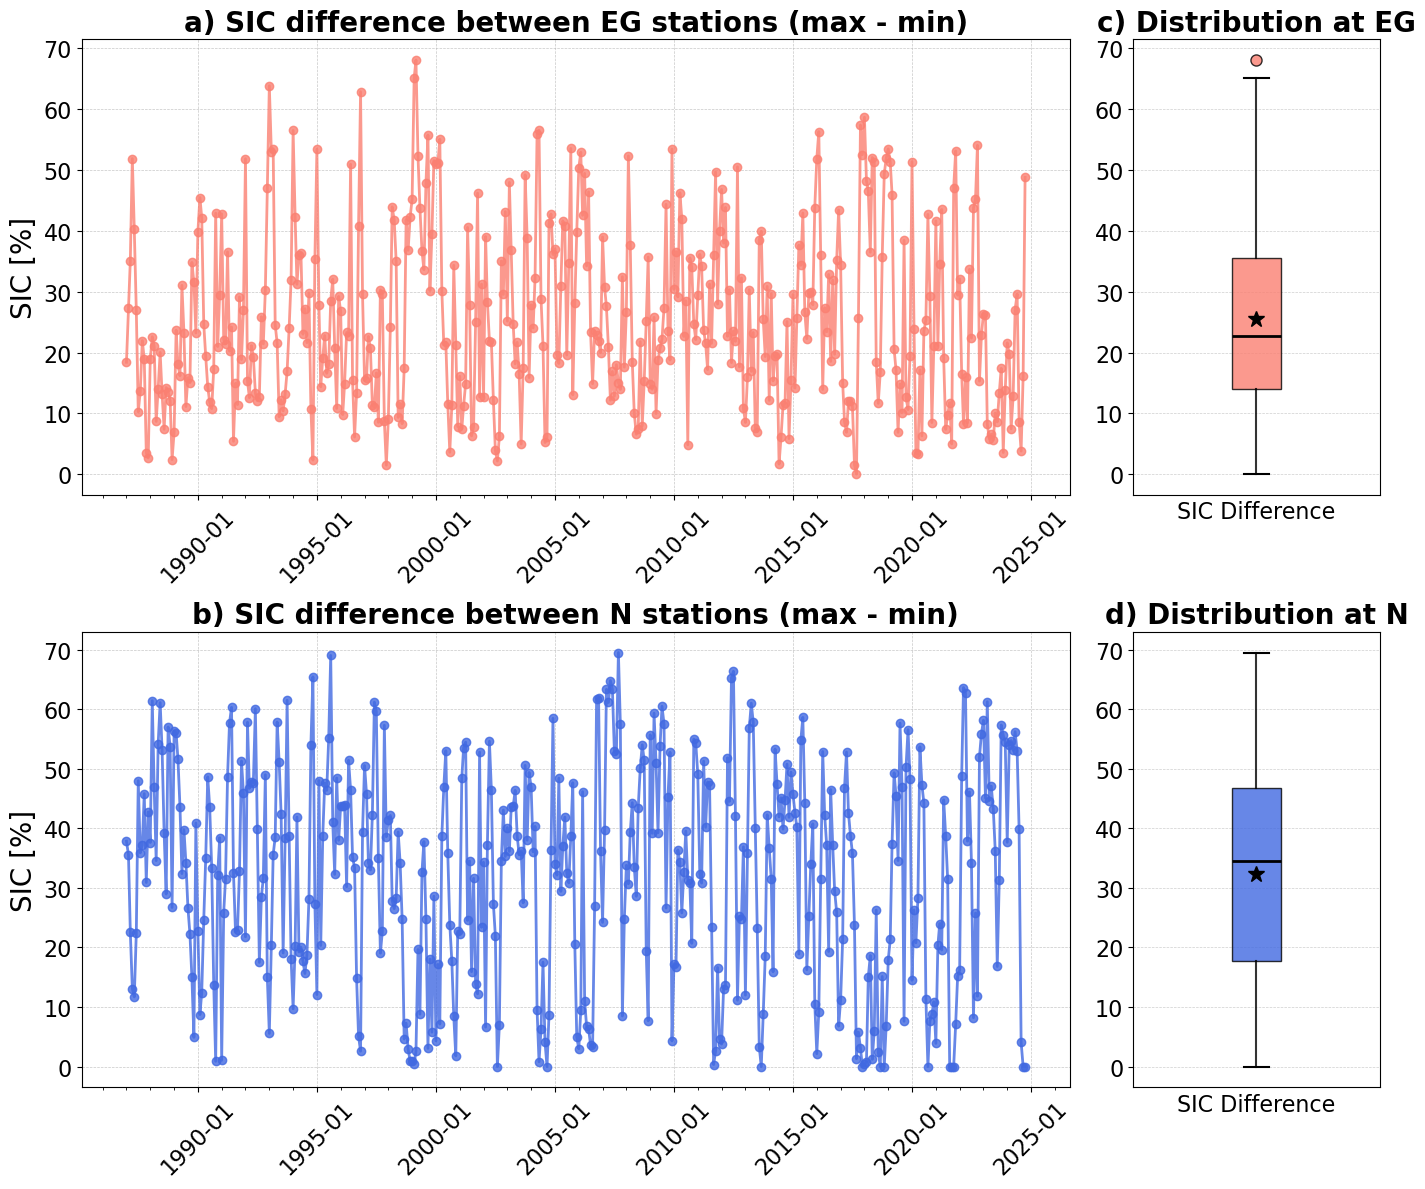

In [120]:
## RANGE PLOT, WITH BOXPLOTS ##
fig = plt.figure(figsize=(14, 12))

# Create a gridspec layout (2 rows, 2 columns)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1])  # 4 parts for the main plot, 1 part for the boxplot

# First plot: SIC difference for EG stations (max - min)
ax1 = fig.add_subplot(gs[0, 0])  # Main plot on the left
ax1.set_title(f'a) SIC difference between EG stations (max - min)', fontsize=fontsize_title, fontweight='bold')
makenice(ax1)
# ax1.plot(date_range, maxdiff_eg, color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax1.plot(date_range, maxdiff_eg, color=col2cluster("EG"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)

# Boxplot for EG stations on the right side
ax2 = fig.add_subplot(gs[0, 1])  # Boxplot on the right
bp_eg = make_boxplot(maxdiff_eg,ax2,col = col2cluster("EG"), title = 'c) Distribution at EG')  # Boxplot on the right)

# Second plot: SIC difference for N stations (max - min)
ax3 = fig.add_subplot(gs[1, 0])  # Main plot on the left
ax3.set_title(f'b) SIC difference between N stations (max - min)', fontsize=fontsize_title, fontweight='bold')
makenice(ax3)
ax3.plot(date_range, maxdiff_n, 
         color=col2cluster("N"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)

# Boxplot for N stations on the right side
ax4 = fig.add_subplot(gs[1, 1])  # Boxplot on the right
bp_n = make_boxplot(maxdiff_n,ax4,col = col2cluster("N"), title = 'd) Distribution at N')  # Boxplot on the right)



# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
#fig.savefig(os.path.join(plotdir, f"hausgarten_sic_range_{firstyear}-{lastyear}_{today}.pdf"), dpi=150, bbox_inches="tight")
#fig.savefig(os.path.join(plotdir_paper, f"hausgarten_sic_range_{firstyear}-{lastyear}.pdf"), dpi=150, bbox_inches="tight")

# Display the plot
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/79058124.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


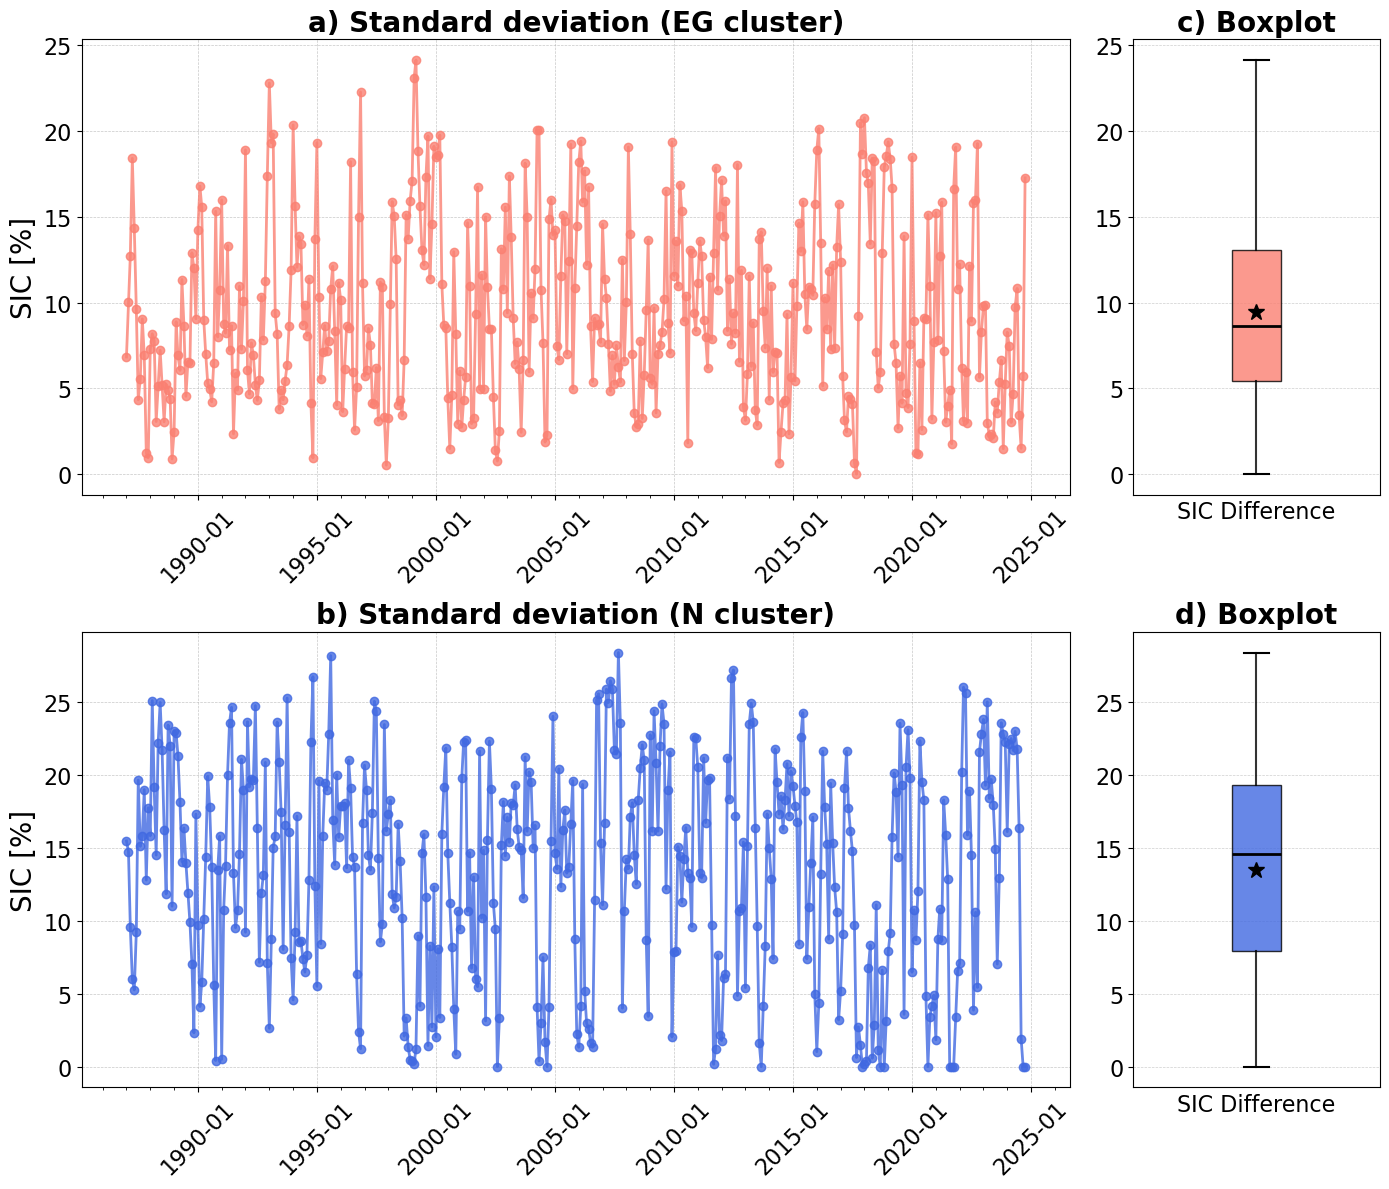

In [121]:
## RANGE PLOT, WITH BOXPLOTS ##
fig = plt.figure(figsize=(14, 12))

# Create a gridspec layout (2 rows, 2 columns)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1])  # 4 parts for the main plot, 1 part for the boxplot

# First plot: SIC difference for EG stations (max - min)
ax1 = fig.add_subplot(gs[0, 0])  # Main plot on the left
ax1.set_title(f'a) Standard deviation (EG cluster)', fontsize=fontsize_title, fontweight='bold')
makenice(ax1)
# ax1.plot(date_range, maxdiff_eg, color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax1.plot(date_range, std_eg, color=col2cluster("EG"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)

# Boxplot for EG stations on the right side
ax2 = fig.add_subplot(gs[0, 1])  # Boxplot on the right
bp_eg = make_boxplot(std_eg,ax2,col = col2cluster("EG"), title = 'c) Boxplot')  # Boxplot on the right)

# Second plot: SIC difference for N stations (max - min)
ax3 = fig.add_subplot(gs[1, 0])  # Main plot on the left
ax3.set_title(f'b) Standard deviation (N cluster)', fontsize=fontsize_title, fontweight='bold')
makenice(ax3)
ax3.plot(date_range, std_n, 
         color=col2cluster("N"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)

# Boxplot for N stations on the right side
ax4 = fig.add_subplot(gs[1, 1])  # Boxplot on the right
bp_n = make_boxplot(std_n,ax4,col = col2cluster("N"), title = 'd) Boxplot')  # Boxplot on the right)



# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
#fig.savefig(os.path.join(plotdir, f"hausgarten_sic_range_{firstyear}-{lastyear}_{today}.pdf"), dpi=150, bbox_inches="tight")
#fig.savefig(os.path.join(plotdir_paper, f"hausgarten_sic_range_{firstyear}-{lastyear}.pdf"), dpi=150, bbox_inches="tight")

# Display the plot
fig.show()

In [122]:
print(f"Mean/median difference at EG stations: {np.nanmean(maxdiff_eg):.1f}/{np.nanmedian(maxdiff_eg):.1f}")
print(f"Mean/median difference at N stations: {np.nanmean(maxdiff_n):.1f}/{np.nanmedian(maxdiff_n):.1f}")

Mean/median difference at EG stations: 25.5/22.7
Mean/median difference at N stations: 32.3/34.5


In [123]:
## RANGE PLOT, WITHOUT BOXPLOTS ##
if False:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(211)
    ax.set_title(f'a) SIC difference between EG stations (max - min)', fontsize=fontsize_title, fontweight='bold')
    makenice(ax)
    ax.plot(date_range,np.nanmax(sic_mean_eg,axis = 0) - np.nanmin(sic_mean_eg,axis = 0),color=col2cluster("EG"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
    ax = fig.add_subplot(212)
    ax.set_title(f'b) SIC difference between N stations (max - min)', fontsize=fontsize_title, fontweight='bold')
    makenice(ax)
    ax.plot(date_range,np.nanmax(sic_mean_n,axis = 0) - np.nanmin(sic_mean_n,axis = 0),color=col2cluster("N"), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
    #for d in [plotdir,plotdir_paper]:
    plt.tight_layout()
    fig.savefig(os.path.join(plotdir,f"hausgarten_sic_range_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
    fig.savefig(os.path.join(plotdir_paper,f"hausgarten_sic_range_{firstyear}-{lastyear}.pdf"),dpi = 150,bbox_inches = "tight")
    
    fig.show()

In [124]:
mktest_n =  mk.original_test(np.nanmax(sic_mean_n,axis = 0) - np.nanmin(sic_mean_n,axis = 0))
print(f"MK Test yielded {mktest_n[0]} for N cluster, with a pvalue of {mktest_n[2]:.03f} and a slope of {mktest_n[-2]:0.003}")
mktest_eg =  mk.original_test(np.nanmax(sic_mean_eg,axis = 0) - np.nanmin(sic_mean_eg,axis = 0))
print(f"MK Test yielded {mktest_eg[0]} for EG cluster, with a pvalue of {mktest_eg[2]:.03f} and a slope of {mktest_eg[-2]:0.003}")

MK Test yielded no trend for N cluster, with a pvalue of 0.289 and a slope of -0.00701
MK Test yielded no trend for EG cluster, with a pvalue of 0.898 and a slope of 0.000612


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2653244171.py:1: RuntimeWarning: All-NaN slice encountered
  mktest_n =  mk.original_test(np.nanmax(sic_mean_n,axis = 0) - np.nanmin(sic_mean_n,axis = 0))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2653244171.py:3: RuntimeWarning: All-NaN slice encountered
  mktest_eg =  mk.original_test(np.nanmax(sic_mean_eg,axis = 0) - np.nanmin(sic_mean_eg,axis = 0))


#### Monthly plots for each station

In [125]:
if False:
    for station_id in station_ids:
        if station_id.startswith("EG"):
            col = col2cluster("EG")
        else:
            col = col2cluster("N")
        df_station = dfdict[station_id]
        fig = plt.figure(figsize = (25,15))
        fig.suptitle(f'{df_station["station_id"][0]}',fontweight = "bold",fontsize = 20,y = .99)
    
        for i,month in enumerate(range(1,13)):
            df_month = df_station[df_station["month"] == month]
            df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
            # Extract the dt array for plotting
            dt_array = df_month['dt'].values
            
            ax = fig.add_subplot(4,3,month)
            #continue
            #ax.set_title(, fontsize=16, fontweight='bold')
            ax.plot(dt_array,df_month["sic_mean"],color=col, linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
            ax.set_ylim((0,100))
            ax.set_title(f'{calendar.month_name[month]}', fontsize=fontsize_title, fontweight='bold')
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
            lr = linregress(df_month["year"][~np.isnan(df_month["sic_mean"])],df_month["sic_mean"][~np.isnan(df_month["sic_mean"])])
            #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
            ax.plot(dt_array,range(firstyear,lastyear+1)*lr.slope+lr.intercept, color='black', linewidth=2.5, linestyle='--')
            stats_text = (f"Slope: {lr.slope:.3f}\n"
                           f"R²: {lr.rvalue**2:.3f}\n"
                           f"p-value: {lr.pvalue:.3f}")
            
            # Box properties for the text
            text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
            
            # Add the text with a box around it
            ax.text(0.7, 0.3, stats_text,
                    transform=ax.transAxes, fontsize=fontsize_labels,
                    verticalalignment='top', horizontalalignment='left',
                    bbox=text_props)
    
            # Improve x-axis formatting
            #plt.xticks(rotation=45)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            
            # Set major ticks to every year
            ax.xaxis.set_minor_locator(mdates.YearLocator())
            ax.tick_params(labelsize = fontsize_labels)
        plt.tight_layout()
        for d in [plotdir,plotdir_paper]:
            fig.savefig(os.path.join(d,f"hausgarten_sic_mean_{station_id}_by_month_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
        plt.close(fig)
        
        #fig.show()
        #sys.exit("ONE STATION")

#### Monthly plots for station average



##### Choose station below

In [130]:
treat_eg = False
treat_n = !treat_eg
if treat_eg:
    stations = stations_eg
    stationname = "EG"
    xpos_lr,ypos_lr = 0.72, 0.32
    xpos_stats,ypos_stats = 0.02, 0.32
else:
    stations = stations_n
    stationname = "N"
    xpos_lr,ypos_lr = 0.75, 0.9
    xpos_stats,ypos_stats = 0.05, 0.9

#### Below: Timeseries

100.0

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/484033027.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/484033027.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/484033027.py:10: SettingWithCopyWarning: 
A 

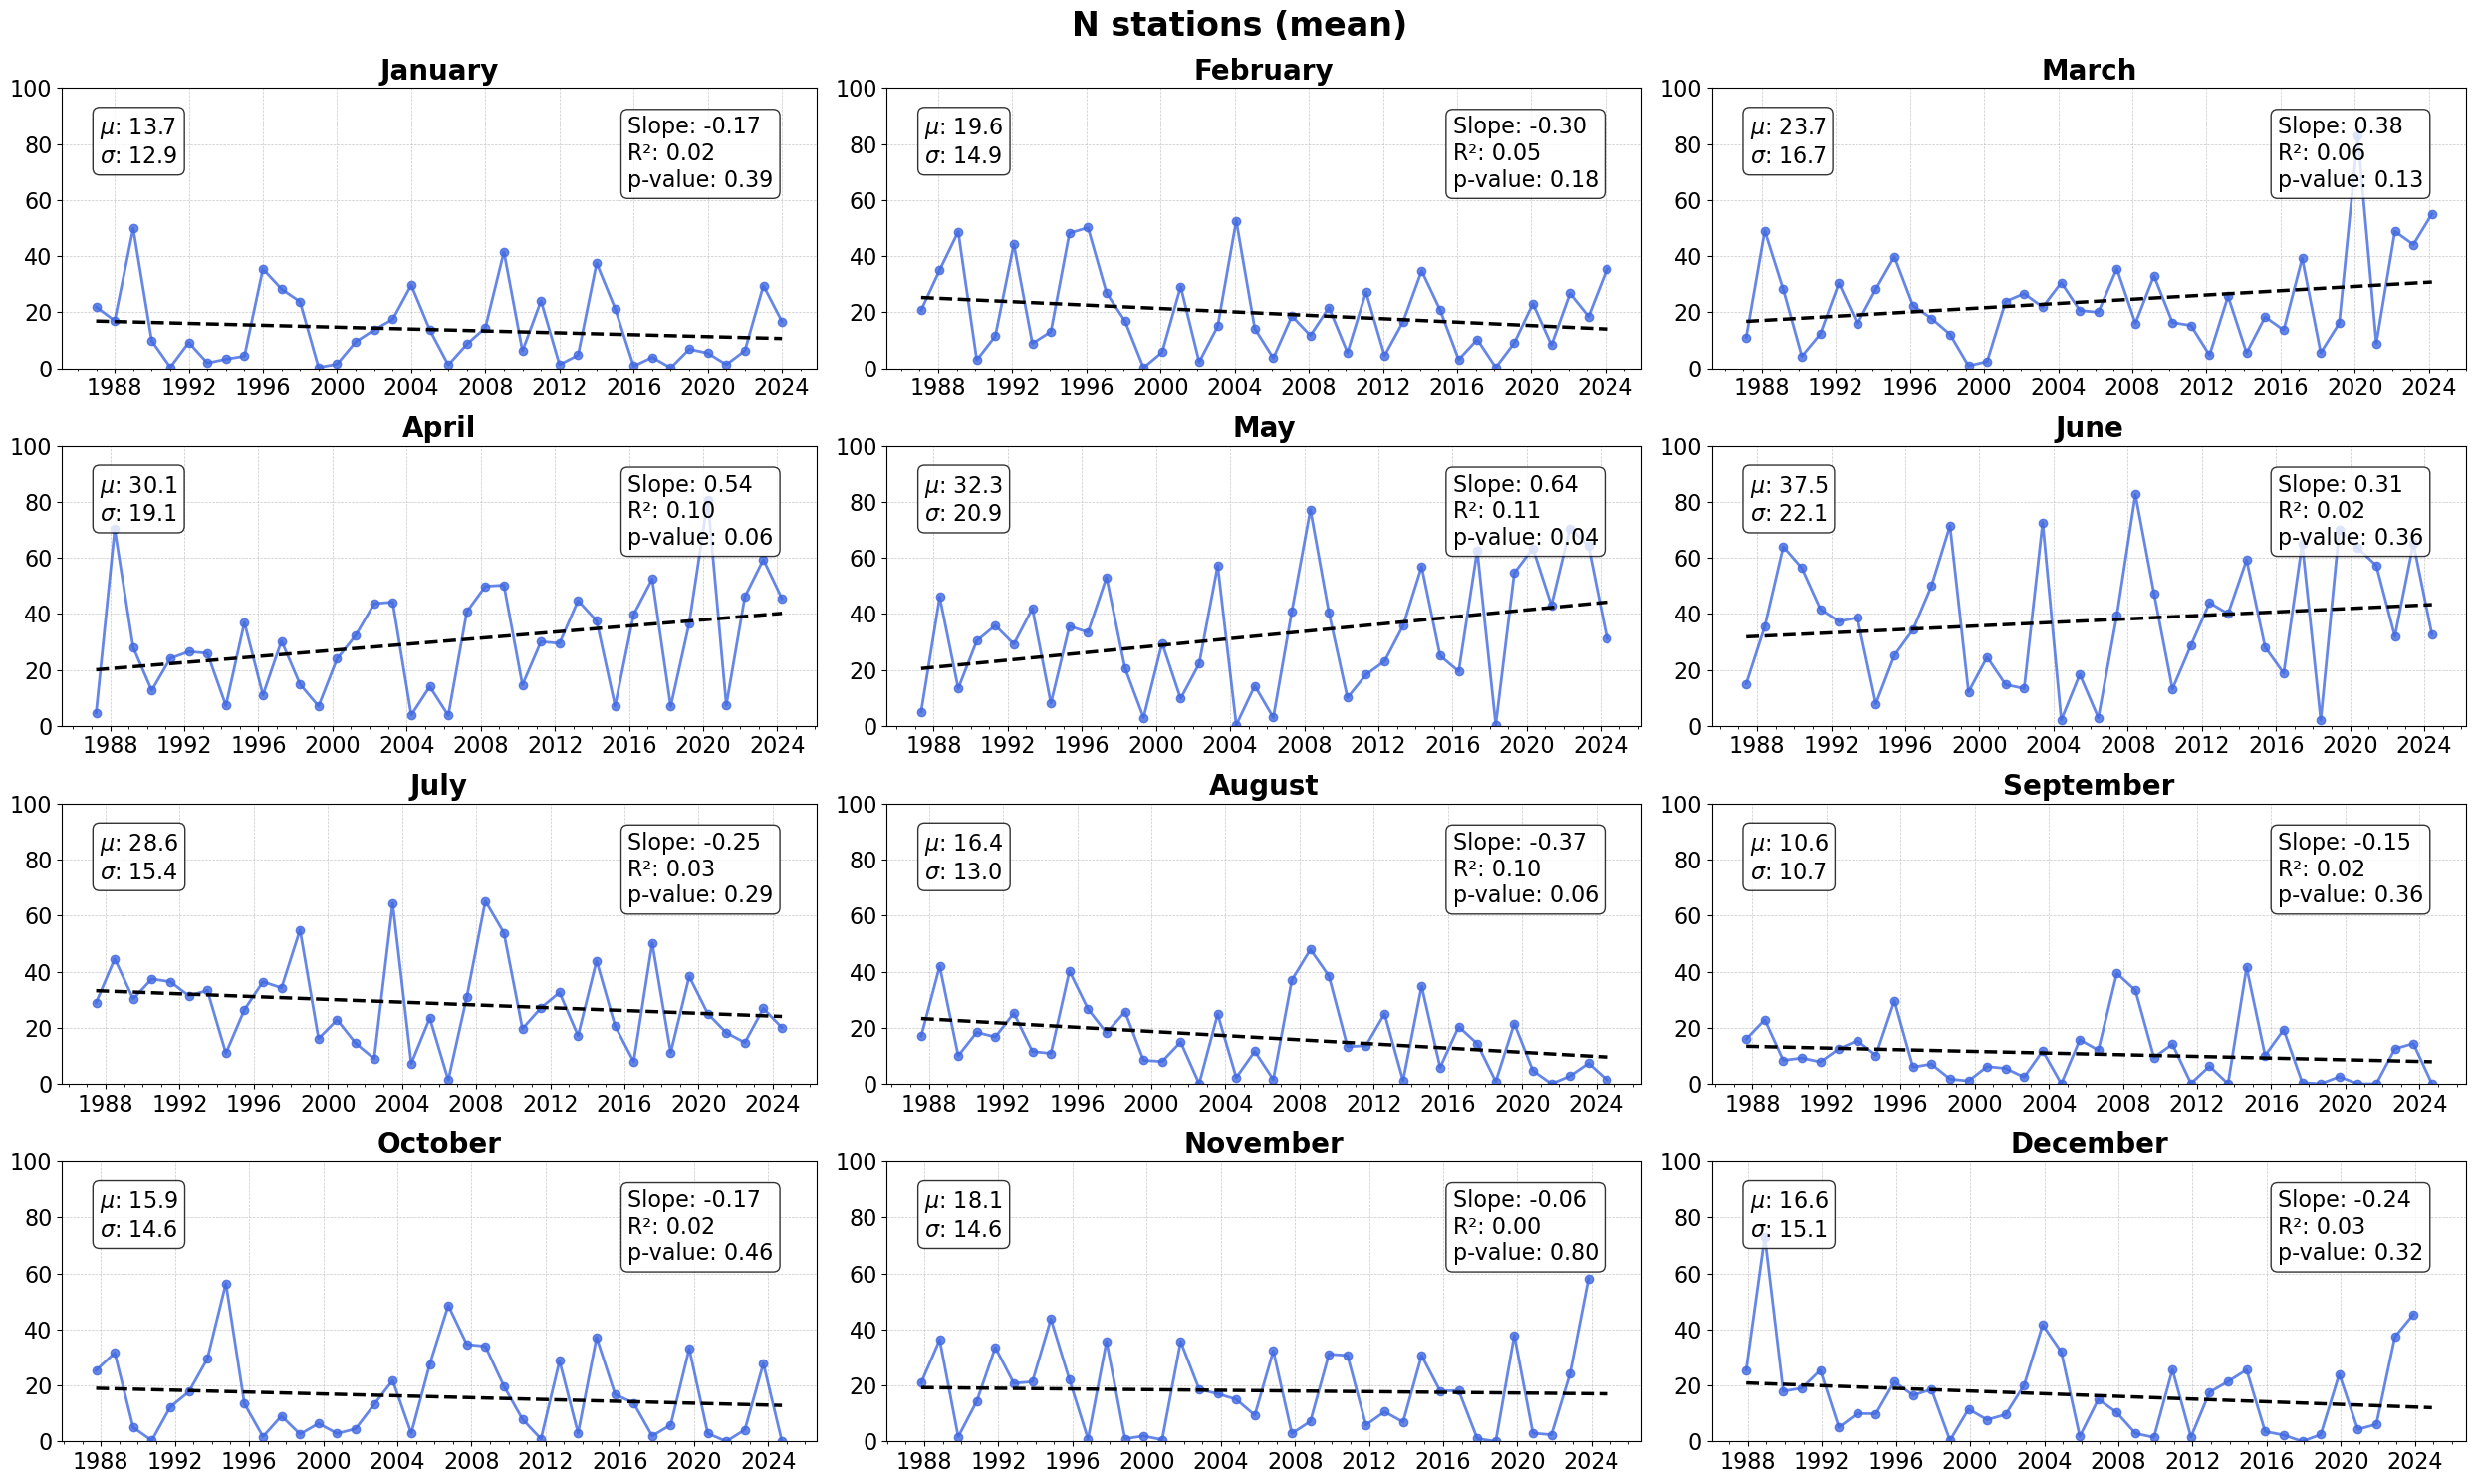

In [135]:
fig = plt.figure(figsize = (25,15))
fig.suptitle(f'{stationname} stations (mean)',fontweight = "bold",fontsize = fontsize_suptitle,y = .99)

for i,month in enumerate(range(1,13)):
    sic_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(stations):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month_stations[i,:] = df_month["sic_mean"]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
    sic_mean_stations = np.nanmean(sic_month_stations,axis = 0)
    #sys.exit()                                           
    # Extract the dt array for plotting
    dt_array = df_month['dt'].values
    
    ax = fig.add_subplot(4,3,month)
    #ax.set_title(, fontsize=16, fontweight='bold')
    ax.plot(dt_array,sic_mean_stations,color=col2cluster(stationname), linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
    ax.set_ylim((0,100))
    ax.set_title(f'{calendar.month_name[month]}', fontsize=fontsize_title, fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    lr = linregress(df_month["year"][~np.isnan(sic_mean_stations)],sic_mean_stations[~np.isnan(sic_mean_stations)])
    #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
    ax.plot(dt_array,range(firstyear,lastyear+1)*lr.slope+lr.intercept, color='black', linewidth=2.5, linestyle='--')
    lr_text = (f"Slope: {lr.slope:.2f}\n"
                   f"R²: {lr.rvalue**2:.2f}\n"
                   f"p-value: {lr.pvalue:.2f}")
    stats_text = (r"$\mu$"+f": {np.nanmean(sic_mean_stations):.1f}\n" + r"$\sigma$"+f": {np.nanstd(sic_mean_stations):.1f}")
    # Box properties for the text
    text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    
    # Add the text with a box around it
    ax.text(xpos_lr,ypos_lr, lr_text,
            transform=ax.transAxes, fontsize=fontsize_labels,
            verticalalignment='top', horizontalalignment='left',
            bbox=text_props)
    ax.text(xpos_stats,ypos_stats,stats_text,
            transform=ax.transAxes, fontsize=fontsize_labels,
            verticalalignment='top', horizontalalignment='left',
            bbox=text_props)
    # Improve x-axis formatting
    #plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    ax.tick_params(labelsize = fontsize_labels)
plt.tight_layout()

fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_ALL_{stationname}_by_month_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
for ending in [".png",".pdf"]:
    fig.savefig(os.path.join(plotdir_paper,f"hausgarten_sic_mean_ALL_{stationname}_by_month_{firstyear}-{lastyear}{ending}"),dpi = 300,bbox_inches = "tight")
#plt.close(fig)
fig.show()

In [132]:
print(f"SIC change integrated over entire period for EG stations in Aug Sep Oct: {37*np.array([0.6,0.66,0.48])}, rest insignificant")
print(f"SIC change integrated over entire period for N stations in May: {37*np.array([0.64])}, rest insignificant")

SIC change integrated over entire period for EG stations in Aug Sep Oct: [22.2  24.42 17.76], rest insignificant
SIC change integrated over entire period for N stations in May: [23.68], rest insignificant


#### Below: Mann Kendall test

In [133]:
print(f"{stationname} stations")
for i,month in enumerate(range(1,13)):
    sic_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(stations):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month_stations[i,:] = df_month["sic_mean"]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
    sic_mean_stations = np.nanmean(sic_month_stations,axis = 0)
    print(month)
    mktest_month =  mk.original_test(sic_mean_stations)
    if mktest_month[0] != "no trend":
        print(f"MK Test yielded significance for month {month}, with an {mktest_month[0]} trend, a pvalue of {mktest_month[2]:.03f} and a slope of {mktest_month[-2]:0.003}")
        sys.exit()

#fig.show()

N stations
1
2
3
4
MK Test yielded significance for month 4, with an increasing trend, a pvalue of 0.029 and a slope of 0.635


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2528674051.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2528674051.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2528674051.py:8: SettingWithCopyWarning: 
A 

SystemExit: 

/Users/vludwig/opt/anaconda3/envs/sinxs/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### Correlation to SIE

In [58]:
df_sie = pd.read_csv(os.path.join(datadir_csv,f"sie_osisaf_198701-202412.csv"))

In [60]:
## BY STATION AND MONTH
#print(f"{stationname} stations")
for month in range(1,13):
    print(f"### {month} ###")
    #sic_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(station_ids_by_lon):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month_station = df_month["sic_mean"]
        sie_month = df_sie["sie"][df_station["month"]==month]
        nanmask = np.logical_or(np.isnan(sic_month_station),np.isnan(sie_month))
        corr = pearsonr(sic_month_station[~nanmask],sie_month[~nanmask])
        if corr.pvalue<=.05:
            print(station_id)
            print(f"Correlation coefficient (R) {corr.statistic:0.2f} significant with pvalue {corr.pvalue:0.2f}")
            print(f"Coefficient of determination (R^2) {corr.statistic**2:0.2f} significant with pvalue {corr.pvalue:0.2f}")
        else:
            continue
            print("No significant correlation")


### 1 ###
### 2 ###
### 3 ###
### 4 ###
### 5 ###
### 6 ###
### 7 ###
### 8 ###
EG-IV
Correlation coefficient (R) 0.37 significant with pvalue 0.02
Coefficient of determination (R^2) 0.13 significant with pvalue 0.02
### 9 ###
### 10 ###
EG-I
Correlation coefficient (R) 0.34 significant with pvalue 0.04
Coefficient of determination (R^2) 0.11 significant with pvalue 0.04
EG-II
Correlation coefficient (R) 0.32 significant with pvalue 0.05
Coefficient of determination (R^2) 0.10 significant with pvalue 0.05
EG-III
Correlation coefficient (R) 0.32 significant with pvalue 0.05
Coefficient of determination (R^2) 0.10 significant with pvalue 0.05
### 11 ###
### 12 ###


In [66]:
## BY CLUSTER AND MONTH
treat_eg = False
treat_n = !treat_eg
if treat_eg:
    stations = stations_eg
    stationname = "EG"
else:
    stations = stations_n
    stationname = "N"
print(f"{stationname} stations")
for i,month in enumerate(range(1,13)):
    sic_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(stations):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month_stations[i,:] = df_month["sic_mean"]
        sic_month_stations_mean = np.nanmean(sic_month_stations,axis = 0)
    sie_month = df_sie["sie"][df_station["month"]==month]
    nanmask = np.logical_or(np.isnan(sic_month_stations_mean),np.isnan(sie_month))
    corr = pearsonr(sic_month_stations_mean[~nanmask],sie_month[~nanmask])
    if corr.pvalue<=.05:
        print(f"Correlation coefficient (R) {corr.statistic:0.2f} significant with pvalue {corr.pvalue:0.2f}")
        print(f"Coefficient of determination (R^2) {corr.statistic**2:0.2f} significant with pvalue {corr.pvalue:0.2f}")
    else:
        #continue
        print("No significant correlation")



N stations
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation
No significant correlation


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/2980622983.py:17: RuntimeWarning: Mean of empty slice
  sic_month_stations_mean = np.nanmean(sic_month_stations,axis = 0)


In [67]:
sic_cluster = np.zeros((df_station_all_dates.shape[0],len(stations)))

In [68]:
## BY CLUSTER, FOR ENTIRE TIMESERIES
treat_eg = True
treat_n = !treat_eg
if treat_eg:
    stations = stations_eg
    stationname = "EG"
else:
    stations = stations_n
    stationname = "N"
print(f"{stationname} stations")

sic_cluster = np.zeros((df_station_all_dates.shape[0],len(stations)))
for i_station,station in enumerate(stations):
    sic_cluster[:,i_station] = df_station_all_dates[station]

sic_month_cluster_mean = np.nanmean(sic_cluster,axis = 1)
sie_month = df_sie["sie"]
nanmask = np.logical_or(np.isnan(sic_month_cluster_mean),np.isnan(sie_month))
corr = pearsonr(sic_month_cluster_mean[~nanmask],sie_month[~nanmask])
print(f"Correlation coefficient (R) {corr.statistic:0.2f} significant with pvalue {corr.pvalue:0.2f}")
print(f"Coefficient of determination (R^2) {corr.statistic**2:0.2f} significant with pvalue {corr.pvalue:0.2f}")


EG stations
Correlation coefficient (R) 0.65 significant with pvalue 0.00
Coefficient of determination (R^2) 0.42 significant with pvalue 0.00


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/763002438.py:16: RuntimeWarning: Mean of empty slice
  sic_month_cluster_mean = np.nanmean(sic_cluster,axis = 1)


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/755533570.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


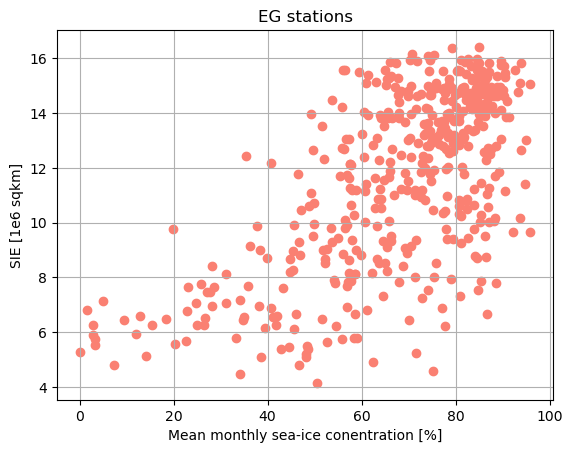

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f"{stationname} stations")
ax.set_xlabel("Mean monthly sea-ice conentration [%]")
ax.set_ylabel("SIE [1e6 sqkm]")
ax.scatter(sic_month_cluster_mean,sie_month,color = col2cluster(stationname))
ax.grid()
fig.show()

In [70]:
## FOR ALL STATIONS, FOR ENTIRE TIMESERIES
sic_cluster = np.zeros((df_station_all_dates.shape[0],len(station_ids)))
for i_station,station in enumerate(stations):
    sic_cluster[:,i_station] = df_station_all_dates[station]

sic_mean = np.nanmean(df_station_all,axis = 1)
sie_month = df_sie["sie"]
nanmask = np.logical_or(np.isnan(sic_mean),np.isnan(sie_month))
corr = pearsonr(sic_mean[~nanmask],sie_month[~nanmask])
print(f"Correlation coefficient (R) {corr.statistic:0.2f} significant with pvalue {corr.pvalue:0.2f}")
print(f"Coefficient of determination (R^2) {corr.statistic**2:0.2f} significant with pvalue {corr.pvalue:0.2f}")


Correlation coefficient (R) 0.54 significant with pvalue 0.00
Coefficient of determination (R^2) 0.29 significant with pvalue 0.00


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/484169608.py:6: RuntimeWarning: Mean of empty slice
  sic_mean = np.nanmean(df_station_all,axis = 1)


/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/424520661.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


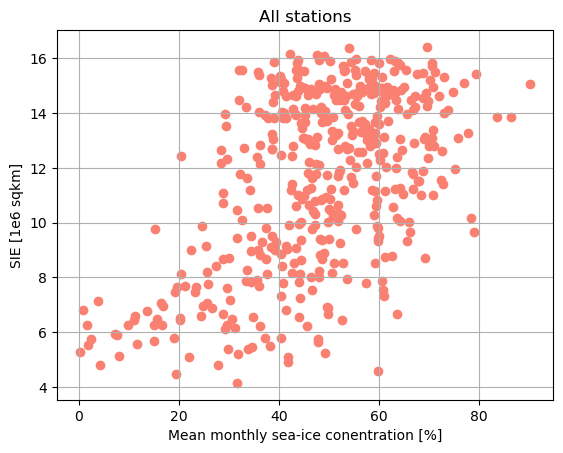

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f"All stations")
ax.set_xlabel("Mean monthly sea-ice conentration [%]")
ax.set_ylabel("SIE [1e6 sqkm]")
ax.scatter(sic_mean,sie_month,color = col2cluster(stationname))
ax.grid()
fig.show()

##### Check for normal distribution

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_2069/3833531271.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


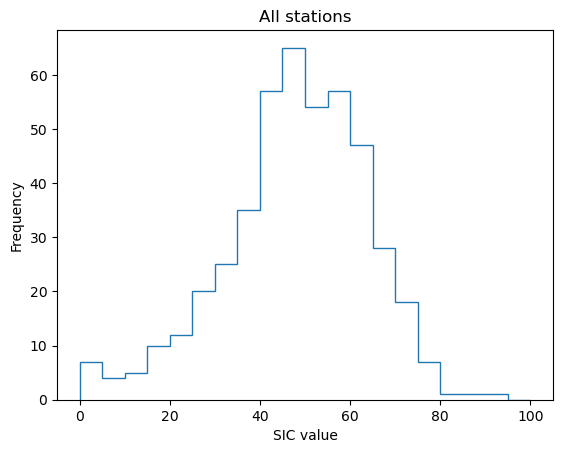

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("All stations")
ax.set_ylabel("Frequency")
ax.set_xlabel("SIC value")
ax.hist(sic_mean,histtype="step",bins = np.arange(0,105,5))
#ax.plot(x, y, color='red', label='Gaussian Curve')
fig.show()

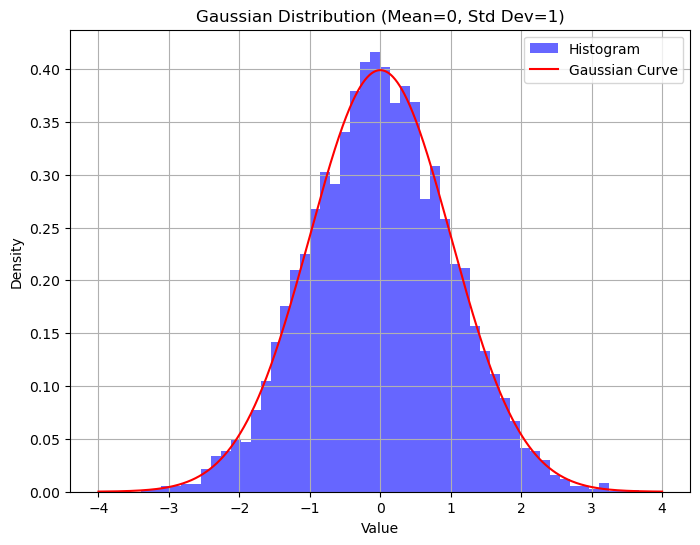

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Gaussian distribution
mean = 0  # Mean (m)
std_dev = 1  # Standard deviation (s)

# Generate random data
num_samples = 10000  # Number of samples
data = np.random.normal(mean, std_dev, num_samples)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.6, color='blue', label='Histogram')

# Generate a smooth Gaussian curve
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
plt.plot(x, y, color='red', label='Gaussian Curve')

# Add labels and legend
plt.title('Gaussian Distribution (Mean={}, Std Dev={})'.format(mean, std_dev))
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
